In [1]:
from discopy import Ty, Word

s, n = Ty('s'), Ty('n')
Alice, loves, Bob = Word('Alice', n), Word('loves', n.r @ s @ n.l), Word('Bob', n)

print("Vocabulary:\n{}".format('\n'.join(map(repr, [Alice, loves, Bob]))))

Vocabulary:
Word('Alice', Ty('n'))
Word('loves', Ty(Ob('n', z=1), 's', Ob('n', z=-1)))
Word('Bob', Ty('n'))


Diagram for 'Alice loves Bob':


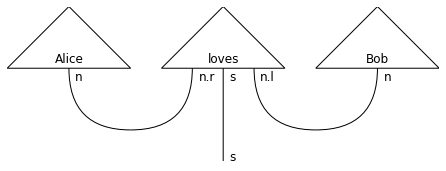

In [2]:
from discopy import Diagram, Id, Box, Cup, Cap
from discopy.grammar import draw

grammar = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

sentences = {"{} {} {}.".format(subj, verb, obj): subj @ verb @ obj >> grammar
             for subj in [Alice, Bob] for verb in [loves] for obj in [Alice, Bob]}

print("Diagram for 'Alice loves Bob':")
draw(sentences["Alice loves Bob."], draw_types=True)

Diagram for 'Alice loves Bob', with snakes removed:


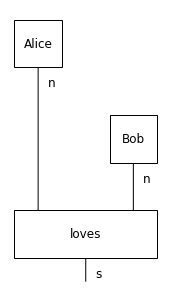

In [3]:
from discopy import Functor

love_box = Box('loves', n @ n, s)
love_ansatz = Cap(n.r, n) @ Cap(n, n.l) >> Id(n.r) @ love_box @ Id(n.l)

A = Functor(
    ob={s: s, n: n},
    ar={Alice: Alice, Bob: Bob, loves: love_ansatz})

diagrams = {string: A(sentence).normal_form() for string, sentence in sentences.items()}

print("Diagram for 'Alice loves Bob', with snakes removed:")
diagrams["Alice loves Bob."].draw()

In [4]:
sentences = list(sentences.keys())
print("Grammatical sentences:\n{}".format('\n'.join(sentences)))

Grammatical sentences:
Alice loves Alice.
Alice loves Bob.
Bob loves Alice.
Bob loves Bob.


In [20]:
from discopy.quantum import Ket, H, Rx, CX, sqrt, Measure, CGate

def weights(params):
    return CGate("weights: {}".format(list(params)), 2, 0, params)

def verb_ansatz(params):
    return CX >> sqrt(2) @ H @ Rx(params[0])\
        >> Measure(2) >> weights(params[1:])

params0 = [0.5, 1., 0., 0., 0.]

Circuit for 'Alice loves Bob':


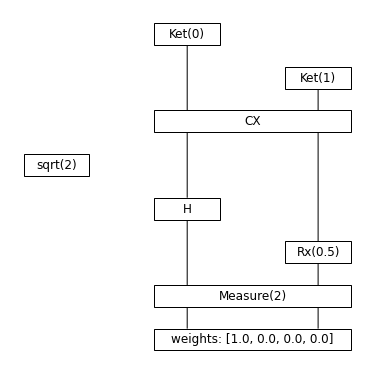

In [21]:
from discopy.quantum import bit, qubit, BitsAndQubits, CQCircuit

ob = {s: Ty(), n: qubit}
ar = lambda params: {
    Alice: Ket(0), Bob: Ket(1),
    love_box: verb_ansatz(params)}

F = lambda params: Functor(ob, ar(params), ob_factory=BitsAndQubits, ar_factory=CQCircuit)

print("Circuit for 'Alice loves Bob':")
F(params0)(diagrams['Alice loves Bob.']).draw(
    aspect='auto', draw_types=False, figsize=(5, 5))

In [39]:
from jax import jit

epsilon = 1e-2

def evaluate(params, sentence):
    return F(params)(diagrams[sentence]).eval().array.real

@jit
def corpus(params):
    return {sentence: evaluate(params, sentence) for sentence in sentences}

corpus0 = corpus(params0)

print("True sentences:\n{}\n".format('\n'.join(sentence
    for sentence, probability in corpus0.items() if probability > 1 - epsilon)))
print("False sentences:\n{}".format('\n'.join(sentence
    for sentence, probability in corpus0.items() if probability < epsilon)))

True sentences:
Alice loves Bob.
Bob loves Alice.

False sentences:
Alice loves Alice.
Bob loves Bob.


In [40]:
import jax.numpy as np
from jax import grad

def mean_squared(y_true, y_pred):
    return np.mean((np.array(y_true) - np.array(y_pred)) ** 2)

@jit
def mean_squared_loss(params):
    c = corpus(params)
    return mean_squared(*zip(*[(corpus0[sentence], c[sentence]) for sentence in sentences]))

grad(mean_squared_loss)(params0)

[DeviceArray(0., dtype=float32),
 DeviceArray(-0., dtype=float32),
 DeviceArray(-0., dtype=float32),
 DeviceArray(-0., dtype=float32),
 DeviceArray(-0., dtype=float32)]

In [41]:
from jax import vmap

f = lambda x: mean_squared_loss([x] + params0[1:])
x = np.arange(0.0, 1.0, 0.01)
y = vmap(f)(x)
dy = vmap(grad(f))(x)

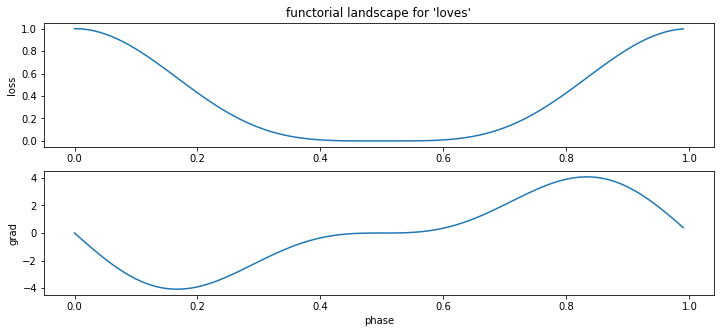

In [42]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 5)

plt.subplot(2, 1, 1)
plt.plot(x, y)
plt.title("functorial landscape for 'loves'")
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(x, dy)
plt.xlabel('phase')
plt.ylabel('grad')
plt.show()

In [43]:
from sklearn.model_selection import train_test_split

sentence_train, sentence_test = train_test_split(sentences, test_size=0.25, random_state=42)

print("Training set:\n{}\n".format('\n'.join(sentence_train)))
print("Testing set:\n{}".format('\n'.join(map(
    lambda x: 'Does ' + x.replace('loves', 'love').replace('.', '?'), sentence_test))))

Training set:
Bob loves Bob.
Alice loves Alice.
Bob loves Alice.

Testing set:
Does Alice love Bob?


In [45]:
from jax import jit
from time import time

loss = {
    sentence: lambda params:
        mean_squared(corpus0[sentence], evaluate(params, sentence))
        for sentence in sentences}

step_size = 1e-2

@jit
def update(params):
    for sentence in sentence_train:
        params = params - step_size * grad(loss[sentence])(params)
    return params

start = time()
print("{1:.3f} seconds to compile the update function just in time:\n{0}".format(
    update(np.array(params0)), time() - start))

8.566 seconds to compile the update function just in time:
[0.5 1.  0.  0.  0. ]


In [47]:
@jit
def testing_loss(params):
    return np.mean(np.array([loss[sentence](params) for sentence in sentence_test]))

start = time()
print("{1:.3f} seconds to compile the testing loss of params0 ({0})".format(
    testing_loss(params0), time() - start))

2.698 seconds to compile the testing loss of params0 (0.0)


In [62]:
from random import random, seed; seed(420)

print("Random parameter initialisation...")

params = np.array([random() for _ in range(5)])
print("Initial parameters: {}".format(params))

print("Initial testing loss: {:.5f}\n".format(testing_loss(params)))

epochs, iterations = 7, 10

for epoch in range(epochs):
    start = time()
    for i in range(iterations):
        params = update(params)

    print("Epoch {} ({:.3f} milliseconds)".format(epoch, 1e3 * (time() - start)))
    print("Testing loss: {:.5f}".format(testing_loss(params)))
    print("params = {}\n".format(params))

Random parameter initialisation...
Initial parameters: [0.02634338 0.78136903 0.27260637 0.0955924  0.6636843 ]
Initial testing loss: 0.76977

Epoch 0 (5.787 milliseconds)
Testing loss: 0.06664
params = [ 0.00274024  0.47193706  0.27174383 -0.21383967  0.66282177]

Epoch 1 (5.797 milliseconds)
Testing loss: 0.00575
params = [ 0.00066911  0.38080707  0.27174136 -0.30496967  0.66281945]

Epoch 2 (4.343 milliseconds)
Testing loss: 0.00050
params = [ 4.1753100e-04  3.5403037e-01  2.7174136e-01 -3.3174637e-01
  6.6281945e-01]

Epoch 3 (4.782 milliseconds)
Testing loss: 0.00004
params = [ 3.6180715e-04  3.4616208e-01  2.7174136e-01 -3.3961466e-01
  6.6281945e-01]

Epoch 4 (5.343 milliseconds)
Testing loss: 0.00000
params = [ 3.4675619e-04  3.4384999e-01  2.7174136e-01 -3.4192675e-01
  6.6281945e-01]

Epoch 5 (3.200 milliseconds)
Testing loss: 0.00000
params = [ 3.4244204e-04  3.4317055e-01  2.7174136e-01 -3.4260619e-01
  6.6281945e-01]

Epoch 6 (4.261 milliseconds)
Testing loss: 0.00000
para

In [63]:
print("Does Alice love Bob?")
print("Yes" if evaluate(params, 'Alice loves Bob.') > .9 else "No")

Does Alice love Bob?
Yes


In [64]:
for x, y in corpus(params).items(): print(x, y)

Alice loves Alice. 0.00016613459
Alice loves Bob. 0.9345595
Bob loves Alice. 0.9345595
Bob loves Bob. 0.00016613459
